In [1]:

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import sys

customized_path= "/content/gdrive/MyDrive/MR-Contribtion-LSTM"
sys.path.append(customized_path)

In [3]:

import os
import re
import numpy as np
import tensorflow as tf
import random

import pandas as pd
import keras
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns



In [4]:
#training constants
MAX_SEQ_LEN = 19 #this is based on a quick analysis of the len of sequences train['text'].apply(lambda x : len(x.split(' '))).quantile(0.95)
DEFAULT_BATCH_SIZE =16


In [5]:
trainData=pd.read_csv('/content/gdrive/MyDrive/MR-Contribtion-LSTM/train.csv',encoding='utf-8')

In [6]:
testData=pd.read_csv('/content/gdrive/MyDrive/MR-Contribtion-LSTM/test.csv')

In [7]:
data=pd.read_csv('/content/gdrive/MyDrive/MR-Contribtion-LSTM/data.csv')

In [8]:
print(trainData.shape)
print(testData.shape)

(827, 4)
(205, 4)


In [9]:
trainData['text'].apply(lambda x : len(x.split(' '))).quantile(0.95)


19.0

In [ ]:
# def clean_text(text, mapping):
#     replace_white_space = ["\n"]
#     for s in replace_white_space:
#         text = text.replace(s, " ")
#     replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
#     for s in replace_punctuation:
#         text = text.replace(s, "'")

#     # Random note: removing the URL's slightly degraded performance, it's possible the model learned that certain URLs were positive/negative
#     # And was able to extrapolate that to retweets. Could also explain why re-training the Embeddings improves performance.
#     # remove twitter url's
# #     text = re.sub(r"http[s]?://t.co/[A-Za-z0-9]*","TWITTERURL",text)
#     mapped_string = []
#     for t in text.split(" "):
#         if t in mapping:
#             mapped_string.append(mapping[t])
#         elif t.lower() in mapping:
#             mapped_string.append(mapping[t.lower()])
#         else:
#             mapped_string.append(t)
#     return ' '.join(mapped_string)

In [10]:
# Get tweets from Data frame and convert to list of "texts" scrubbing based on clean_text function
# CONTRACTION_MAPPING is a map of common contractions(e.g don't => do not)

train_text_vec = trainData['text'].values
test_text_vec = testData['text'].values


# tokenize the sentences
tokenizer = Tokenizer(lower=False) #original
#tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(train_text_vec)
train_text_vec = tokenizer.texts_to_sequences(train_text_vec)
test_text_vec = tokenizer.texts_to_sequences(test_text_vec)

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN)

print('Number of Tokens:', len(tokenizer.word_index))
print("Max Token Index:", train_text_vec.max(), "\n")

print('Sample Tweet Before Processing:', trainData["text"].values[0])
#print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[0]]), '\n')

print('What the model will interpret:', train_text_vec[0].tolist())

Number of Tokens: 3125
Max Token Index: 3125 

Sample Tweet Before Processing: best clet tout might inspir trip video stor search bet movy expery
What the model will interpret: [0, 0, 0, 0, 0, 0, 0, 31, 1354, 1355, 45, 207, 585, 99, 832, 833, 64, 2, 164]


In [11]:

# One Hot Encode Y values:
encoder = LabelEncoder()
y_train = encoder.fit_transform(trainData['class'].values)
y_train = to_categorical(y_train)

y_test = encoder.fit_transform(testData['class'].values)
y_test = to_categorical(y_test)




In [12]:
# get an idea of the distribution of the text values
from sklearn.utils import class_weight
from collections import Counter
ctr = Counter(trainData['class'].values)
print('Distribution of Classes:', ctr)

# get class weights for the training data, this will be used data
y_train_int = np.argmax(y_train,axis=1)
cws = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train_int),  y=y_train_int)
print(cws)
class_weightss = dict(zip(np.unique(y_train_int), class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train_int),  y=y_train_int)))
print(class_weightss)

Distribution of Classes: Counter({0: 551, 1: 276})
[0.75045372 1.49818841]
{0: 0.7504537205081669, 1: 1.4981884057971016}


In [13]:
#
print('Dominant Class: ', ctr.most_common(n = 1)[0][0])
print('Baseline Accuracy Dominant Class', (ctr.most_common(n = 1)[0][0] == testData['class'].values).mean())

preds = np.zeros_like(y_test)
preds[:, 0] = 1
preds[0] = 1 #done to suppress warning from numpy for f1 score
print('F1 Score:', f1_score(y_test, preds, average='weighted'))

Dominant Class:  0
Baseline Accuracy Dominant Class 0.6682926829268293
F1 Score: 0.5354157752103837


In [14]:

train_size = len(trainData)
val_size = int(0.1 * train_size)
real_train_size = train_size - val_size

In [15]:

x_realTrain=train_text_vec[0:real_train_size]
y_realTrain=y_train[0:real_train_size]
x_Val=train_text_vec[real_train_size:train_size]
y_Val=y_train[real_train_size:train_size]


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_ma(y_true, y_pred, class_names,filename):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig('/content/gdrive/MyDrive/MR-Contribtion-LSTM/'+ filename + '.png', dpi=300)
    return plt.show()

In [19]:
def threshold_search(y_true, y_proba, average = None):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold, average=average)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result


def train(model,
          X_train, y_real_train, X_test, y_test,
          checkpoint_path='model.hdf5',
          epcohs = 25,
          batch_size = DEFAULT_BATCH_SIZE,
          class_weights = None,
          fit_verbose=2,
          print_summary = True,
          filename='filename'):
    m = model()
    if print_summary:
        print(m.summary())
        print(m.count_params())
    m.fit(
        X_train,
        y_real_train,
        validation_data=(x_Val, y_Val),
        epochs=epcohs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks= [
            ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(patience = 10)
        ],
        verbose=fit_verbose
    )

    print("\n\n****************************\n\n")
    print('Loading Best Model...')
    from keras import backend as K


    predictions = m.predict(X_test, verbose=1)
    np.savetxt("/content/gdrive/MyDrive/MR-Contribtion-LSTM/predictions.txt", predictions.argmax(axis = 1), fmt = "%d")
    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
    x=classification_report(y_test.argmax(axis = 1),predictions.argmax(axis = 1),digits=4)
    print(x)
    from sklearn.metrics import roc_curve,roc_auc_score,average_precision_score

    fpr , tpr , thresholds = roc_curve ( y_test.argmax(axis = 1) ,predictions.argmax(axis = 1))
    auc_score=roc_auc_score(y_test.argmax(axis = 1) ,predictions.argmax(axis = 1))
    print('auc_score',round(auc_score,4))
    AVg_Precision=average_precision_score(y_test.argmax(axis = 1) ,predictions.argmax(axis = 1))
    print('AVg_Precision',round(AVg_Precision,4))
    print('fpr',fpr)
    print('tpr',tpr)
    from imblearn.metrics import geometric_mean_score
    Gmean=geometric_mean_score(y_test.argmax(axis = 1) ,predictions.argmax(axis = 1))
    print('GMEAN',round(Gmean,4))
    print('thresholds',thresholds)
    labelList=["Negative","Positive"]
    confusion_ma(y_test.argmax(axis = 1), predictions.argmax(axis = 1), labelList, filename)
    return fpr,tpr,thresholds
    #return m #returns best performing model


In [20]:
np.savetxt("/content/gdrive/MyDrive/MR-Contribtion-LSTM/y_test.txt", y_test.argmax(axis = 1), fmt = "%d")

In [21]:
GCN_Val=np.loadtxt('/content/gdrive/MyDrive/MR-Contribtion-LSTM/GCN_Val.txt')
print(GCN_Val.shape)

(82, 2)


In [22]:
GCN_Test=np.loadtxt('/content/gdrive/MyDrive/MR-Contribtion-LSTM/GCN_test.txt')
print(GCN_Test.shape)

(205, 2)


In [23]:
GCN_Values=np.loadtxt('/content/gdrive/MyDrive/MR-Contribtion-LSTM/GCN_Values.txt')
print(GCN_Values.shape)

(745, 2)


In [24]:
def threshold_search(y_true, y_proba, average = None):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold, average=average)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result


def train2(model,
          X_train,GCN_Values, y_real_train, X_test, y_test,
          checkpoint_path='model.hdf5',
          epcohs = 25,
          batch_size = DEFAULT_BATCH_SIZE,
          class_weights = None,
          fit_verbose=2,
          print_summary = True,
           filename='filename'):
    m = model()
    if print_summary:
        print(m.summary())
    m.fit(
        [X_train,GCN_Values],
        y_real_train,
        validation_data=([x_Val,GCN_Val], y_Val),
        epochs=epcohs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks= [
            ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(patience = 10)
        ],
        verbose=fit_verbose
    )
    #print(m.layers[3].output)
    print("\n\n****************************\n\n")
    print('Loading Best Model...')

    from keras import backend as K



    predictions = m.predict([X_test,GCN_Test], verbose=1)
    np.savetxt("/content/gdrive/MyDrive/MR-Contribtion-LSTM/predictions_MMCT-GCN.txt", predictions.argmax(axis = 1), fmt = "%d")
    #print(predictions)
    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))

    x=classification_report(y_test.argmax(axis = 1),predictions.argmax(axis = 1),digits=4)
    print(x)
    from sklearn.metrics import roc_curve,roc_auc_score,average_precision_score

    fpr , tpr , thresholds = roc_curve ( y_test.argmax(axis = 1) ,predictions.argmax(axis = 1))
    auc_score=roc_auc_score(y_test.argmax(axis = 1) ,predictions.argmax(axis = 1))
    print('auc_score',round(auc_score,4))
    AVg_Precision=average_precision_score(y_test.argmax(axis = 1) ,predictions.argmax(axis = 1))
    print('fpr',fpr)
    print('tpr',tpr)
    from imblearn.metrics import geometric_mean_score
    Gmean=geometric_mean_score(y_test.argmax(axis = 1) ,predictions.argmax(axis = 1))
    print('GMEAN',round(Gmean,4))
    print('thresholds',thresholds)
    labelList=["Negative","Positive"]
    confusion_ma(y_test.argmax(axis = 1), predictions.argmax(axis = 1), labelList,filename)
    #return m,x #returns best performing model
    return fpr,tpr,thresholds


In [ ]:
#LSTM-fineTuned
# version 3 to test seed

print("Version 3")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)
def model_1tuned():

    #my_init = keras.initializers.glorot_uniform(seed=1)
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(LSTM(200))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    out=Dense(2, activation='softmax')
    #yy=keras.layers.add([out, out])
    #y=out+b
    model.add(out)
    #model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    # Model file name
    return model
'''
m1,x1 = train(model_1tuned,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights=class_weightss,
           filename='LSTM'
           )



In [ ]:
#LSTM-fineTuned-200 million capacity
# version 3 to test seed
print("Version 3")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)
def model_1tuned():

    #my_init = keras.initializers.glorot_uniform(seed=1)
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 170, input_length = MAX_SEQ_LEN))
    model.add(LSTM(400))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    out=Dense(2, activation='softmax')
    #yy=keras.layers.add([out, out])
    #y=out+b
    model.add(out)
    #model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    # Model file name
    return model
#'''
m1,x1 = train(model_1tuned,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights=class_weightss,
           filename='LSTM'
           )
#'''

In [ ]:
#LSTM-fineTuned-2
# version 3 to test seed
print("Version 3")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)
def model_2tuned():

    #my_init = keras.initializers.glorot_uniform(seed=1)
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(LSTM(200))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(50, activation='sigmoid'))
    out=Dense(2, activation='softmax')
    #yy=keras.layers.add([out, out])
    #y=out+b
    model.add(out)
    #model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    # Model file name
    return model
#'''
m1,x1 = train(model_2tuned,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_2tuned.h5',
           class_weights=class_weightss,
           filename='LSTM-Tuned-V2'
           )
#'''

In [ ]:
# #Comopute the mean of differences
# d_bar = np.mean(diff)
# #compute the variance of differences
# sigma2 = np.var(diff)
# #compute the number of data points used for training
# n1 = 4540
# #compute the number of data points used for testing
# n2 = 1135
# #compute the total number of data points
# #n = len(data)
# n=5675

# #compute the modified variance
# sigma2_mod = sigma2 * (1/n + n2/n1)
# #compute the t_static
# t_static =  d_bar / np.sqrt(sigma2_mod)
# from scipy.stats import t
# #Compute p-value and plot the results
# Pvalue = ((1 - t.cdf(t_static, n-1))*200)
# #Pvalue

Version 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 128)           400128    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 542,114
Trainable params: 542,114
Non-trainable params: 0
_________________________________________________________________
None
542114
Epoch 1/25


47/47 - 6s - loss: 0.6949 - accuracy: 0.6523 - val_loss: 0.6933 - val_accuracy: 0.4878 - 6s/epoch - 134ms/step
Epoch 2/25


47/47 - 1s - loss: 0.5866 - accuracy: 0.7477 - val_loss: 0.8001 - val_accuracy: 0.5976 - 1s/epoch - 28ms/step
Epoch 3/25


47/47 - 2s - loss: 0.1563 - accuracy: 0.9409 - val_loss: 1.0473 - val_accuracy: 0.6098 - 2s/epoch - 33ms/step
Epoch 4/25


47/47 - 1s - loss: 0.0453 - accuracy: 0.9906 - val_loss: 1.6467 - val_accuracy: 0.5732 - 1s/epoch - 31ms/step
Epoch 5/25


47/47 - 1s - loss: 0.0128 - accuracy: 0.9946 - val_loss: 1.8168 - val_accuracy: 0.6463 - 1s/epoch - 31ms/step
Epoch 6/25


47/47 - 1s - loss: 0.0568 - accuracy: 0.9946 - val_loss: 1.4628 - val_accuracy: 0.6098 - 1s/epoch - 28ms/step
Epoch 7/25


47/47 - 1s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 2.0392 - val_accuracy: 0.6098 - 1s/epoch - 28ms/step
Epoch 8/25


47/47 - 2s - loss: 8.3278e-04 - accuracy: 1.0000 - val_loss: 2.2170 - val_accuracy: 0.5976 - 2s/epoch - 46ms/step
Epoch 9/25


47/47 - 2s - loss: 3.6430e-04 - accuracy: 1.0000 - val_loss: 2.2576 - val_accuracy: 0.6341 - 2s/epoch - 45ms/step
Epoch 10/25


47/47 - 1s - loss: 2.5171e-04 - accuracy: 1.0000 - val_loss: 2.5103 - val_accuracy: 0.6098 - 1s/epoch - 29ms/step
Epoch 11/25


47/47 - 1s - loss: 9.9039e-05 - accuracy: 1.0000 - val_loss: 2.5797 - val_accuracy: 0.6098 - 1s/epoch - 30ms/step


****************************


Loading Best Model...
7/7 [==============================] - 1s 13ms/step
Validation Loss: 2.1125816381173323
Test Accuracy 0.7170731707317073
F1 Score: 0.712244853831517
              precision    recall  f1-score   support

           0     0.7724    0.8175    0.7943       137
           1     0.5833    0.5147    0.5469        68

    accuracy                         0.7171       205
   macro avg     0.6779    0.6661    0.6706       205
weighted avg     0.7097    0.7171    0.7122       205

auc_score 0.6661
AVg_Precision 0.4612
fpr [0.         0.18248175 1.        ]
tpr [0.         0.51470588 1.        ]
GMEAN 0.6487
thresholds [2 1 0]


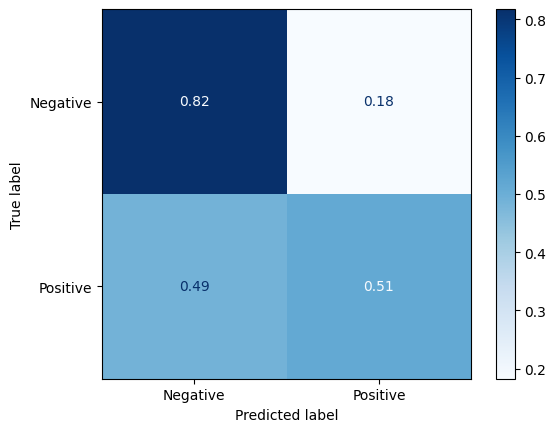

In [ ]:
#LSTM
# version 3 to test seed
print("Version 3")
#np.random.seed(1)
#random.seed(1) # Python

#tf.random.set_seed(1)
#seed = random.randint(1, 3)
#np.random.seed(seed)
#random.seed(seed)
#tf.random.set_seed(seed)
def model_12LSTM():

    #my_init = keras.initializers.glorot_uniform(seed=1)
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    #model.add(LSTM(128,activation='relu')) this line add value to our code
    model.add(LSTM(128))
    #model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    #model.add(Dense(2, activation='relu'))
    out=Dense(2, activation='softmax')
    #yy=keras.layers.add([out, out])
    #y=out+b
    model.add(out)
    #model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    #model.compile(loss='mean_absolute_percentage_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    # Model file name
    return model
#m7,m8,m9 = train(model_12LSTM,
m7,m8,m9 = train(model_12LSTM,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_12LSTM.h5',
           class_weights=class_weightss,
           filename='LSTM'
           )


In [ ]:
#from mlxtend.evaluate import paired_ttest_5x2cv
#t, p = paired_ttest_5x2cv(estimator1=m,estimator2=m,X= x_realTrain, y=y_test)

In [ ]:
fpr_LSTM=[]
tpr_LSTM=[]
threshold_LSTM=[]
print(m1)
print(m2)
print(m3)
print(m4)
print(m5)
print(m6)
print(m7)
print(m8)
print(m9)
fpr_LSTM.append(m1)
fpr_LSTM.append(m4)
fpr_LSTM.append(m7)
tpr_LSTM.append(m2)
tpr_LSTM.append(m5)
tpr_LSTM.append(m8)
threshold_LSTM.append(m3)
threshold_LSTM.append(m6)
threshold_LSTM.append(m9)
def avg_CM(ConfusionMatrix):
   sum_e1=0
   for array in ConfusionMatrix:
    #print(array)
    sum_e1+=array
    #print(sum_e1)
   average_CM=sum_e1/len(ConfusionMatrix)


   return  average_CM
fpr_LSTM=avg_CM(fpr_LSTM)
tpr_LSTM=avg_CM(tpr_LSTM)
threshold_LSTM=avg_CM(threshold_LSTM)
print(fpr_LSTM)
print(tpr_LSTM)
print(threshold_LSTM)

In [ ]:
tpr_LSTM


In [ ]:
from sklearn.metrics import auc
auc_LSTM = auc(fpr_LSTM, tpr_LSTM)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ourLSTM, tpr_ourLSTM, label='MMCT-GCN-LSTM (area = {:.4f})'.format(auc_ourLSTM))
plt.plot(fpr_LSTM, tpr_LSTM, label='LSTM (area = {:.4f})'.format(auc_LSTM))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
'''
scores = list()
i=1
while i <=5:
  m1,x_lstm = train(model_12,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights=class_weightss,
           filename='LSTM'
           )

  scores.append(x_lstm)
  i+=1
'''


In [ ]:
'''
P_0,R_0,F1_0=avg('0')
#print (avg('0'))
#print (avg('1'))
print(" Accuracy: {:.2f} \n".format(avg('accuracy')))
print(" Macro_average: {:.2f} \n".format(avg('macro avg')))
print("Class negative:\n************************\n Precision: {:.2f} \n Recall: {:.2f}  \n f1-Score: {:.2f}".format(P_0, R_0, F1_0))
#P_fake,R_fake,F1_fake=avg('1')
P_1,R_1,F1_1=avg('1')
print("Class positive:\n************************\n Precision: {:.2f} \n Recall: {:.2f}  \n f1-Score: {:.2f}".format(P_1, R_1, F1_1))
'''

Version 3
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 19, 128)      400128      ['input_5[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          131584      ['embedding_2[0][0]']            
                                                                                                  
 dense_6 (Dense)                (None, 64)           8256        ['lstm_2[0][0]']                 
                                                                                  

47/47 - 6s - loss: 0.2159 - accuracy: 0.9879 - val_loss: 0.1359 - val_accuracy: 0.9756 - 6s/epoch - 132ms/step
Epoch 2/25


47/47 - 2s - loss: 0.1049 - accuracy: 0.9960 - val_loss: 0.0868 - val_accuracy: 1.0000 - 2s/epoch - 39ms/step
Epoch 3/25


47/47 - 1s - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.9878 - 1s/epoch - 30ms/step
Epoch 4/25


47/47 - 1s - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.1128 - val_accuracy: 0.9634 - 1s/epoch - 29ms/step
Epoch 5/25


47/47 - 1s - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.2129 - val_accuracy: 0.8902 - 1s/epoch - 28ms/step
Epoch 6/25


47/47 - 1s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.5949 - val_accuracy: 0.8293 - 1s/epoch - 31ms/step
Epoch 7/25


47/47 - 1s - loss: 3.7335e-04 - accuracy: 1.0000 - val_loss: 0.5533 - val_accuracy: 0.8049 - 1s/epoch - 28ms/step
Epoch 8/25


47/47 - 1s - loss: 1.4794e-04 - accuracy: 1.0000 - val_loss: 0.7203 - val_accuracy: 0.7927 - 1s/epoch - 29ms/step
Epoch 9/25


47/47 - 1s - loss: 1.1747e-04 - accuracy: 1.0000 - val_loss: 0.7436 - val_accuracy: 0.7927 - 1s/epoch - 27ms/step
Epoch 10/25


47/47 - 2s - loss: 4.0180e-05 - accuracy: 1.0000 - val_loss: 0.8444 - val_accuracy: 0.7805 - 2s/epoch - 45ms/step
Epoch 11/25


47/47 - 2s - loss: 2.6274e-05 - accuracy: 1.0000 - val_loss: 0.9037 - val_accuracy: 0.7805 - 2s/epoch - 43ms/step
Epoch 12/25


47/47 - 1s - loss: 1.8223e-05 - accuracy: 1.0000 - val_loss: 0.9633 - val_accuracy: 0.7683 - 1s/epoch - 29ms/step
Epoch 13/25


47/47 - 1s - loss: 1.3163e-05 - accuracy: 1.0000 - val_loss: 1.0228 - val_accuracy: 0.7805 - 1s/epoch - 26ms/step


****************************


Loading Best Model...
7/7 [==============================] - 1s 16ms/step
Validation Loss: 1.6569967468323994
Test Accuracy 0.6731707317073171
F1 Score: 0.6759281301584668
              precision    recall  f1-score   support

           0     0.7652    0.7372    0.7509       137
           1     0.5068    0.5441    0.5248        68

    accuracy                         0.6732       205
   macro avg     0.6360    0.6407    0.6379       205
weighted avg     0.6795    0.6732    0.6759       205

auc_score 0.6407
fpr [0.         0.26277372 1.        ]
tpr [0.         0.54411765 1.        ]
GMEAN 0.6334
thresholds [2 1 0]


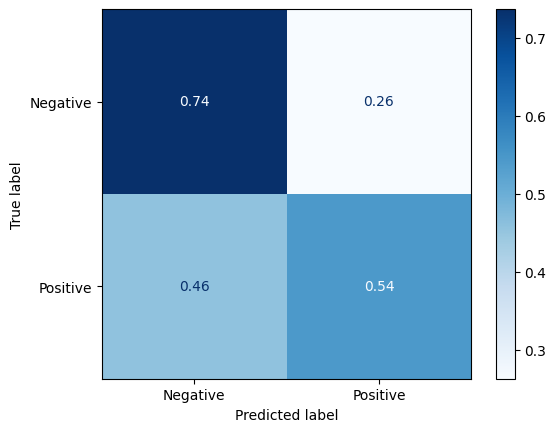

In [ ]:
##Contribution
# version 5 to test merged models using concate
print("Version 3")
#np.random.seed(7.1)
#random.seed(1) # Python

#tf.random.set_seed(1)
#seed = random.randint(1, 10)
#np.random.seed(seed)
#random.seed(seed)
#tf.random.set_seed(seed)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import concatenate,add,subtract,maximum,Softmax,LeakyReLU,BatchNormalization
from sklearn import preprocessing

#my_init = keras.initializers.glorot_uniform(seed=1)
def merged_model_1LSTM():
  input = Input((19,))
  layer1=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN)(input)
  layer2=LSTM(128)(layer1)
  layer3=Dense(64, activation='relu')(layer2)
  layer4=Dense(32, activation='relu')(layer3)
  #layer4=Dense(2, activation='relu')(layer4)
  #normalized_LSTM = BatchNormalization()(layer4)
  inp = Input((2,))
  #out=tf.keras.layers.Rescaling(scale=1.*1000000)(inp)
  out = Lambda(lambda x: K.identity(x))(inp)
  #normalized_GCN = BatchNormalization()(out)
  #out=inp
  #out = Lambda(lambda x: K.identity(x))(inp)
  #out = Lambda(lambda x: K.identity(x))(inp)
  #out=tf.keras.layers.LeakyReLU(0.2)(out)
  #out=Dense(2)(inp)
  #out=Dense(2,activation='softmax')(inp)
  #out=(2)(inp)
  #out = tf.keras.layers.Softmax()(out)
  #out=Dense(2)(inp)
  merge=concatenate([layer4, out])
  #layer6=Dense(16, activation='relu')(merge)
  #merge=add([layer4, out])
  #layer5=Dense(32, activation='relu')(merge)
  layer5=Dense(2, activation='softmax')(merge)
  merged_model=Model(inputs=[input, inp],outputs=layer5)
  #merged_model.add(add([model.output, model2.output]))
  #tf.keras.layers.Add()([x1, x2])
  #tf.keras.layers.Add()([x1, x2])
  merged_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  return merged_model


m7,m8,m9= train2(merged_model_1LSTM,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='merged_model_1LSTM.h5',
           class_weights=class_weightss,
           filename='Text-GCN+LSTM-Tuned'
           )


In [ ]:
test_text_vec

In [ ]:
##XContribution
# version 5 to test merged models using concate
print("Version 3")
#np.random.seed(1)
#random.seed(1) # Python

tf.random.set_seed(3)
#seed = random.randint(1, 3)
#np.random.seed(seed)
#random.seed(seed)
#tf.random.set_seed(seed)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import concatenate,add,subtract,maximum,Softmax,LeakyReLU,GRU
from sklearn import preprocessing

#my_init = keras.initializers.glorot_uniform(seed=1)
def merged_model_1LSTM():
  input = Input((19,))
  layer1=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN)(input)
  layer2=LSTM(128, activation='relu')(layer1)
  #inp = Input((2,))
  #out = Lambda(lambda x: K.identity(x))(inp)
  #merge=concatenate([layer2, out])
  layer3=Dense(64)(layer2)
  layer4=Dense(32)(layer3)
  #layer5=Dense(32, activation='relu')(layer4)
  inp = Input((2,))

  out = Lambda(lambda x: K.identity(x))(inp)
  #out=tf.keras.layers.Bidirectional(out)
  #merge=concatenate([layer4, out])
  #out=tf.keras.layers.Reshape((2,))(out)
  merge = tf.keras.layers.concatenate([layer4, out])
  #out=tf.keras.layers.LeakyReLU(0.2)(out)
  #out=Dense(2)(inp)
  #out=Dense(2,activation='softmax')(inp)
  #out = tf.keras.layers.Softmax()(out)
  #out=Dense(2)(inp)


  #merge=add([layer4, out])
  layer5=Dense(2, activation='softmax')(merge)
  #layer5=Dense(2, activation='softmax')( layer3)
  merged_model=Model(inputs=[input, inp],outputs=layer5)
  #merged_model.add(add([model.output, model2.output]))
  #tf.keras.layers.Add()([x1, x2])
  #tf.keras.layers.Add()([x1, x2])
  merged_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  return merged_model


m7,m8,m9= train2(merged_model_1LSTM,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='merged_model_1LSTM.h5',
           class_weights=class_weightss,
           filename='Text-GCN+LSTM-Tuned'
           )


In [ ]:

fpr_ourLSTM=[]
tpr_ourLSTM=[]
threshold_ourLSTM=[]
print(m1)
print(m2)
print(m3)
print(m4)
print(m5)
print(m6)
print(m7)
print(m8)
print(m9)
fpr_ourLSTM.append(m1)
fpr_ourLSTM.append(m4)
fpr_ourLSTM.append(m7)
tpr_ourLSTM.append(m2)
tpr_ourLSTM.append(m5)
tpr_ourLSTM.append(m8)
threshold_ourLSTM.append(m3)
threshold_ourLSTM.append(m6)
threshold_ourLSTM.append(m9)
def avg_CM(ConfusionMatrix):
   sum_e1=0
   for array in ConfusionMatrix:
    #print(array)
    sum_e1+=array
    #print(sum_e1)
   average_CM=sum_e1/len(ConfusionMatrix)


   return  average_CM
fpr_ourLSTM=avg_CM(fpr_ourLSTM)
tpr_ourLSTM=avg_CM(tpr_ourLSTM)
threshold=avg_CM(threshold_ourLSTM)
print(fpr_ourLSTM)
print(tpr_ourLSTM)
print(threshold_ourLSTM)

In [ ]:
tpr_ourLSTM

In [ ]:
from sklearn.metrics import auc
auc_ourLSTM = auc(fpr_ourLSTM, tpr_ourLSTM)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ourLSTM, tpr_ourLSTM, label='MMCT-GCN-LSTM (area = {:.4f})'.format(auc_ourLSTM))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
##Contribution22222222
# version 5 to test merged models using concate
print("Version 3")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import concatenate,add,subtract,maximum,Softmax,LeakyReLU,ThresholdedReLU
from sklearn import preprocessing
from keras.regularizers import l2

#my_init = keras.initializers.glorot_uniform(seed=1)
def merged_model_11():
  input = Input((19,))
  layer1=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN)(input)
  layer2=LSTM(128)(layer1)
  layer3=Dense(64, activation='relu')(layer2)
  layer4=Dense(32, activation='relu')(layer3)
  #layer5=Dense(2, activation='relu')(layer4)
  inp = Input((2,))
  out = Lambda(lambda x: K.identity(x))(inp)
  #out=Dense(2,activation='relu')(inp)
  #out = tf.keras.layers.LeakyReLU(0.2)(out)
  #out=ThresholdedReLU(theta=2)(inp)
  #out=Dense(2)(inp)
  merge=concatenate([layer4, out])

  #merge=subtract([layer5, out])
  layer5=Dense(2, activation='softmax')(merge)
  merged_model=Model(inputs=[input, inp],outputs=layer5)
  #merged_model.add(add([model.output, model2.output]))
  #tf.keras.layers.Add()([x1, x2])
  #tf.keras.layers.Add()([x1, x2])
  merged_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  return merged_model


m1,x1= train2(merged_model_11,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='merged_model_1.h5',
           class_weights=class_weightss,
           filename='Text-GCN+LSTM'
           )


In [ ]:

def avg(label):
 sum_accuracy=0
 sum_macro_avg=0
 sum_precision=0
 sum_recall=0
 sum_f1Score=0
 for experiment in scores:
 #for x in experiment.items():
  if label=='accuracy':
   sum_accuracy+=experiment[label]
  elif label=='macro avg':
   sum_macro_avg+=experiment[label]['f1-score']
  else:
    sum_precision+=experiment[label]['precision']
    sum_recall+=experiment[label]['recall']
    sum_f1Score+=experiment[label]['f1-score']
 if label=='accuracy':
  average_accuracy=sum_accuracy/len(scores)
  return average_accuracy
 if label=='macro avg':
  average_macro_avg=sum_macro_avg/len(scores)
  return average_macro_avg
 else:
  average_precision=sum_precision/len(scores)
  average_recall=sum_recall/len(scores)
  average_f1Score=sum_f1Score/len(scores)
 #print(average_precision)
 return average_precision,average_recall,average_f1Score
#print(scores[0]['0']['precision'])


In [ ]:

scores = list()
i=1
while i <=5:
  m1,x1 = train2(merged_model_1LSTM,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='merged_model_1.h5',
           class_weights=class_weightss,
           filename='Text-GCN+LSTM'
           )
  scores.append(x1)
  i+=1


In [ ]:

P_0,R_0,F1_0=avg('0')
#print (avg('0'))
#print (avg('1'))
print(" Accuracy: {:.2f} \n".format(avg('accuracy')))
print(" Macro_average: {:.2f} \n".format(avg('macro avg')))
print("Class negative:\n************************\n Precision: {:.2f} \n Recall: {:.2f}  \n f1-Score: {:.2f}".format(P_0, R_0, F1_0))
#P_fake,R_fake,F1_fake=avg('1')
P_1,R_1,F1_1=avg('1')
print("Class positive:\n************************\n Precision: {:.2f} \n Recall: {:.2f}  \n f1-Score: {:.2f}".format(P_1, R_1, F1_1))


In [ ]:
!pip install keras-tuner -q

In [ ]:
'''
##Contribution-FineTune
# version 5 to test merged models using concate
print("Version 3")
np.random.seed(1)
random.seed(1) # Python
#(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
tf.random.set_seed(1)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import concatenate,add,subtract,maximum,Softmax,LeakyReLU
from sklearn import preprocessing
from tensorflow.keras import layers
from keras_tuner import RandomSearch
#output_dim=hp.Choice("units", values=[128, 200])
#optimizer=hp.Choice("optimizer", values=['adam', 'SGD'])
#units=hp.Int("units", min_value=32, max_value=512, step=32)
def build_model(hp):
  input = Input((19,))
  layer1=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = hp.Choice("output_dim", values=[128, 200]), input_length = MAX_SEQ_LEN)(input)
  layer2=LSTM(units=hp.Choice('units_2', values=[128, 200]))(layer1)
  #hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  layer3=Dense(units=hp.Choice('units_3', values=[64, 100]), activation=hp.Choice("activation_3", values=['relu', 'relu']))(layer2)
  layer4=Dense(units=hp.Choice('units_4', values=[32, 50]), activation=hp.Choice("activation_4", values=['relu', 'relu']))(layer3)

  inp = Input((2,))
  out = Lambda(lambda x: K.identity(x))(inp)
  merge=concatenate([layer4, out])
  layer5=Dense(2, activation='softmax')(merge)
  merged_model=Model(inputs=[input, inp],outputs=layer5)
  merged_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])), metrics=['accuracy'])
  return merged_model

'''
m1= train2(merged_model_1,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='merged_model_1.h5',
           class_weights=class_weightss,
           filename='Text-GCN+LSTM'
           )
'''


In [ ]:
'''
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)
'''

In [ ]:
#tuner.search_space_summary()

In [ ]:
''''
tuner.search([x_realTrain,GCN_Values], y_realTrain, epochs=2,
        callbacks= [
            EarlyStopping(patience = 10)
        ],
        validation_data=([x_Val,GCN_Val], y_Val),
        class_weight=class_weightss,
        verbose=2,
        batch_size=DEFAULT_BATCH_SIZE
        )
        '''

In [ ]:
#models = tuner.get_best_models(num_models=2)

In [ ]:
#tuner.results_summary()

In [ ]:
#print(y_realTrain)
#print(y_test)

In [ ]:
#norm = np.linalg.norm(GCN_Values)
#normal_GCN_Values = GCN_Values/norm

In [ ]:
#print(x_realTrain.shape)

In [ ]:
'''
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model

inp = Input((2,))
out = Lambda(lambda x: K.identity(x))(inp)
model2 = Model(inp,out)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(GCN_Values, y_realTrain)
_, accuracy = model2.evaluate(GCN_Values, y_realTrain)
print('Accuracy: %.2f' % (accuracy*100))
get_3rd_layer_output = K.function([model2.layers[0].input],
                                  [model2.layers[1].output])
layer_output_dummy = get_3rd_layer_output([GCN_Values])[0]
np.savetxt("/content/gdrive/MyDrive/DLRL_Heart Attack/layer_output_dummy.txt", layer_output_dummy, fmt = "%f")

#, epochs=150, batch_size=10
predictions = model2.predict(GCN_Test, verbose=1)
#print(predictions)
print('Validation Loss:', log_loss(y_test, predictions))
print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
#plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
#plt.show()
x=classification_report(y_test.argmax(axis = 1),predictions.argmax(axis = 1))
print(x)
'''

In [ ]:
'''
d = d2 =d3= ""

# Reading data from file1
with open('/content/gdrive/MyDrive/DLRL_Heart Attack/layer_output_train.txt') as fp:
    d = fp.read()

# Reading data from file2
with open('/content/gdrive/MyDrive/DLRL_Heart Attack/layer_output_Val.txt') as fp:
    d2 = fp.read()
    # Reading data from file2
with open('/content/gdrive/MyDrive/DLRL_Heart Attack/layer_output_test.txt') as fp:
    d3 = fp.read()

# Merging 2 files
# To add the data of file2
# from next line
#d += "\n"
d += d2
d += d3

with open ('/content/gdrive/MyDrive/DLRL_Heart Attack/CombinedOutput.txt', 'w') as fp:
    fp.write(d)

    '''

In [ ]:

def avg(label):
 sum_accuracy=0
 sum_precision=0
 sum_recall=0
 sum_f1Score=0
 for experiment in scores:
 #for x in experiment.items():
  if label=='accuracy':
   sum_accuracy+=experiment[label]
  else:
    sum_precision+=experiment[label]['precision']
    sum_recall+=experiment[label]['recall']
    sum_f1Score+=experiment[label]['f1-score']
 if label=='accuracy':
  average_accuracy=sum_accuracy/len(scores)
  return average_accuracy
 else:
  average_precision=sum_precision/len(scores)
  average_recall=sum_recall/len(scores)
  average_f1Score=sum_f1Score/len(scores)
 print(average_precision)
 return average_precision,average_recall,average_f1Score
#print(scores[0]['0']['precision'])


In [ ]:

P_info,R_info,F1_info=avg('0')
print (avg('0'))
print (avg('1'))
#print ("Accuracy"+ avg('accuracy'))
print("Class Informational:\n************************\n Precision: {:.2f} \n Recall: {:.2f}  \n f1-Score: {:.2f}".format(P_info, R_info, F1_info))
P_nonInfo,R_nonInfo,F1_nonInfo=avg('1')


In [ ]:
#BiLSTM
#np.random.seed(1)
#random.seed(1) # Python

#tf.random.set_seed(1)
#seed = random.randint(1, 3)
#np.random.seed(seed)
#random.seed(seed)
#tf.random.set_seed(seed)
def model_1BiLSTM():
    """
    Using a Bidiretional LSTM.
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    #model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

m7,m8,m9= train(model_1BiLSTM,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1BiLSTM.h5',
           class_weights=class_weightss,
          filename='BiLSTM')


In [ ]:
fpr_BiLSTM=[]
tpr_BiLSTM=[]
threshold_BiLSTM=[]
print(m1)
print(m2)
print(m3)
print(m4)
print(m5)
print(m6)
print(m7)
print(m8)
print(m9)
fpr_BiLSTM.append(m1)
fpr_BiLSTM.append(m4)
fpr_BiLSTM.append(m7)
tpr_BiLSTM.append(m2)
tpr_BiLSTM.append(m5)
tpr_BiLSTM.append(m8)
threshold_BiLSTM.append(m3)
threshold_BiLSTM.append(m6)
threshold_BiLSTM.append(m9)
def avg_CM(ConfusionMatrix):
   sum_e1=0
   for array in ConfusionMatrix:
    #print(array)
    sum_e1+=array
    #print(sum_e1)
   average_CM=sum_e1/len(ConfusionMatrix)


   return  average_CM
fpr_BiLSTM=avg_CM(fpr_BiLSTM)
tpr_BiLSTM=avg_CM(tpr_BiLSTM)
threshold_BiLSTM=avg_CM(threshold_BiLSTM)
print(fpr_BiLSTM)
print(tpr_BiLSTM)
print(threshold_BiLSTM)

In [ ]:
tpr_BiLSTM

In [ ]:
from sklearn.metrics import auc
auc_BiLSTM = auc(fpr_BiLSTM, tpr_BiLSTM)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ourLSTM, tpr_ourLSTM, label='MMCT-GCN-LSTM (area = {:.4f})'.format(auc_ourLSTM))
plt.plot(fpr_LSTM, tpr_LSTM, label='LSTM (area = {:.4f})'.format(auc_LSTM))
plt.plot(fpr_BiLSTM, tpr_BiLSTM, label='BiLSTM (area = {:.4f})'.format(auc_BiLSTM))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
x=np.asarray([0. ,0.02311778 , 1. ])

In [ ]:
fpr_BiLSTM

In [ ]:
'''
# version 5 to test merged models(biLSTM) using ADD
print("Version 3")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import concatenate
from keras.layers import add
#my_init = keras.initializers.glorot_uniform(seed=1)
def merged_model_bi():
  #merged_model = Sequential()
  input = Input((19,))
  #model = Sequential()
  layer1=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN)(input)
  #layer2=SpatialDropout1D(0.3)(layer1)
  layer2=Bidirectional(LSTM(128))(layer1)
  layer3=Dense(64, activation='relu')(layer2)
  layer4=Dense(32, activation='relu')(layer3)
  #layer4=Dense(2, activation='softmax')(layer3)

  #inp = Input((2,))
  #out = Lambda(lambda x: K.identity(x))(inp)
    #yy=keras.layers.add([out, out])
    #y=out+b

  inp = Input((2,))
  out = Lambda(lambda x: K.identity(x))(inp)
  #out=ThresholdedReLU(theta=8)(inp)
  #out = Dense(2)(inp)
  merge=concatenate([layer4, out])

  layer5=Dense(2, activation='softmax')(merge)
  merged_model=Model(inputs=[input, inp],outputs=layer5)
  #merged_model.add(add([model.output, model2.output]))
  #tf.keras.layers.Add()([x1, x2])
  #tf.keras.layers.Add()([x1, x2])
  merged_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  #merged_model.fit([x_realTrain,GCN_Values],y_train)

  #print(merged_model.summary())
  return merged_model
#c=merged_model_1()

    # Model file name
#merged_model_1.fit([x_realTrain,GCN_Values],y_train)
m1= train2(merged_model_bi,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights=class_weightss)
'''

In [ ]:
'''
# version 2 to test seed
print("Version 2")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)
def model_1c():
    """
    Adding dropout to reduce overfitting using a bidiretional LSTM
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    #model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Conv1D(64, 4))
#     model.add(Flatten())
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     print(model.summary())
    return model


_ = train(model_1c,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights=class_weightss)

In [ ]:
'''
# version 5 to test merged models using concate
print("Version 3")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import concatenate,add

#my_init = keras.initializers.glorot_uniform(seed=1)
def merged_model_1():
  input = Input((19,))
  layer1=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN)(input)
  #layer2=SpatialDropout1D(0.3)(layer1)
  layer3=Bidirectional(LSTM(128, return_sequences=True))(layer1)
  layer4=Conv1D(64, 4)(layer3)
  layer5=GlobalMaxPool1D()(layer4)
  layer6=Dense(64, activation='relu')(layer5)
  layer7=Dense(32, activation='relu')(layer6)
  inp = Input((2,))
  out = Lambda(lambda x: K.identity(x))(inp)
  #out=ThresholdedReLU(theta=10)(inp)
  #out=Dense(2)(inp)
  merge=concatenate([layer7, out])

  #merge=add([layer3, out])
  layer8=Dense(2, activation='softmax')(merge)
  merged_model=Model(inputs=[input, inp],outputs=layer8)
  #merged_model.add(add([model.output, model2.output]))
  #tf.keras.layers.Add()([x1, x2])
  #tf.keras.layers.Add()([x1, x2])
  merged_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return merged_model


m1= train2(merged_model_1,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights=class_weightss)


In [ ]:
#CNN-finetuned
# version 2 to test seed
print("Version 2")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)

def model_1dCNN_Tuned():

    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    #model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(200, 5,activation='sigmoid'))
    model.add(Conv1D(200, 4,activation='sigmoid'))
    model.add(Conv1D(100, 3,activation='sigmoid'))
    model.add(GlobalMaxPool1D())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

_ = train(model_1dCNN_Tuned,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1dCNN_Tuned',
           class_weights=class_weightss,
          filename='CNN-FineTuned')



In [ ]:
#CNN
# version 2 to test seed
print("Version 2")
# np.random.seed(1)
# random.seed(1) # Python

# tf.random.set_seed(1)
#seed = random.randint(1, 3)
#np.random.seed(seed)
#random.seed(seed)
#tf.random.set_seed(seed)
def model_1d_CNN():

    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 200, input_length = MAX_SEQ_LEN))
    #model.add(SpatialDropout1D(0.3))
    model.add(Conv1D(100, 5))
    model.add(Conv1D(100, 3))
    model.add(Conv1D(64, 2))
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    #model.add(Dense(2, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

m1,m2,m3 = train(model_1d_CNN,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1d_CNN.h5',
           class_weights=class_weightss,
          filename='CNN')



In [ ]:
fpr_CNN=[]
tpr_CNN=[]
threshold_CNN=[]
print(m1)
print(m2)
print(m3)
print(m4)
print(m5)
print(m6)
print(m7)
print(m8)
print(m9)
fpr_CNN.append(m1)
fpr_CNN.append(m4)
fpr_CNN.append(m7)
tpr_CNN.append(m2)
tpr_CNN.append(m5)
tpr_CNN.append(m8)
threshold_CNN.append(m3)
threshold_CNN.append(m6)
threshold_CNN.append(m9)
def avg_CM(ConfusionMatrix):
   sum_e1=0
   for array in ConfusionMatrix:
    #print(array)
    sum_e1+=array
    #print(sum_e1)
   average_CM=sum_e1/len(ConfusionMatrix)


   return  average_CM
fpr_CNN=avg_CM(fpr_CNN)
tpr_CNN=avg_CM(tpr_CNN)
threshold_CNN=avg_CM(threshold_CNN)
print(fpr_CNN)
print(tpr_CNN)
print(threshold_CNN)

In [ ]:
tpr_CNN

In [ ]:
from sklearn.metrics import auc
auc_CNN = auc(fpr_CNN, tpr_CNN)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ourLSTM, tpr_ourLSTM, label='MMCT-GCN-LSTM (area = {:.4f})'.format(auc_ourLSTM))
plt.plot(fpr_LSTM, tpr_LSTM, label='LSTM (area = {:.4f})'.format(auc_LSTM))
plt.plot(fpr_BiLSTM, tpr_BiLSTM, label='BiLSTM (area = {:.4f})'.format(auc_BiLSTM))
plt.plot(fpr_CNN, tpr_CNN, label='CNN (area = {:.4f})'.format(auc_CNN))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:

#Text-GCN+CNN-Finetune
# version 5 to test merged models using concate
print("Version 3")
# np.random.seed(1)
# random.seed(1) # Python

# tf.random.set_seed(1)
#seed = random.randint(1, 3)
#np.random.seed(seed)
#random.seed(seed)
#tf.random.set_seed(seed)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import concatenate,add

#my_init = keras.initializers.glorot_uniform(seed=1)
def merged_model_1CNN_Tuned():
  input = Input((19,))
  layer1=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 200, input_length = MAX_SEQ_LEN)(input)
  #layer2=SpatialDropout1D(0.3)(layer1)
  layer3=Conv1D(100, 5)(layer1)
  layer4= Conv1D(100, 3)(layer3)
  layer5=Conv1D(64, 2)(layer4)
  #layer5=SpatialDropout1D(0.1)(layer5)
  layer6=GlobalMaxPool1D()(layer5)
  layer7=Dense(64, activation='relu')(layer6)
  layer8=Dense(32, activation='relu')(layer7)
  #layer8=Dense(2, activation='relu')(layer8)
  inp = Input((2,))
  #out = Lambda(lambda x: K.identity(x*1000000))(inp)
  out = Lambda(lambda x: K.identity(x))(inp)
  merge=concatenate([layer8, out])
  #merge=add([layer3, out])
  layer9=Dense(2, activation='softmax')(merge)
  merged_model=Model(inputs=[input, inp],outputs=layer9)
  merged_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  return merged_model


m7,m8,m9= train2(merged_model_1CNN_Tuned,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='merged_model_1CNN_Tuned.h5',
           class_weights=class_weightss,
           filename='Text-GCN+CNN-Tuned')


In [ ]:
fpr_ourCNN=[]
tpr_ourCNN=[]
threshold_ourCNN=[]
print(m1)
print(m2)
print(m3)
print(m4)
print(m5)
print(m6)
print(m7)
print(m8)
print(m9)
fpr_ourCNN.append(m1)
fpr_ourCNN.append(m4)
fpr_ourCNN.append(m7)
tpr_ourCNN.append(m2)
tpr_ourCNN.append(m5)
tpr_ourCNN.append(m8)
threshold_ourCNN.append(m3)
threshold_ourCNN.append(m6)
threshold_ourCNN.append(m9)
def avg_CM(ConfusionMatrix):
   sum_e1=0
   for array in ConfusionMatrix:
    #print(array)
    sum_e1+=array
    #print(sum_e1)
   average_CM=sum_e1/len(ConfusionMatrix)


   return  average_CM
fpr_ourCNN=avg_CM(fpr_ourCNN)
tpr_ourCNN=avg_CM(tpr_ourCNN)
threshold_ourCNN=avg_CM(threshold_ourCNN)
print(fpr_ourCNN)
print(tpr_ourCNN)
print(threshold_ourCNN)

In [ ]:
tpr_ourCNN

In [ ]:
from sklearn.metrics import auc
auc_ourCNN = auc(fpr_ourCNN, tpr_ourCNN)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ourLSTM, tpr_ourLSTM, label='MMCT-GCN-LSTM (area = {:.4f})'.format(auc_ourLSTM))
plt.plot(fpr_LSTM, tpr_LSTM, label='LSTM (area = {:.4f})'.format(auc_LSTM))
plt.plot(fpr_BiLSTM, tpr_BiLSTM, label='BiLSTM (area = {:.4f})'.format(auc_BiLSTM))
plt.plot(fpr_CNN, tpr_CNN, label='CNN (area = {:.4f})'.format(auc_CNN))
plt.plot(fpr_ourCNN, tpr_ourCNN, label='MMCT-GCN-CNN (area = {:.4f})'.format(auc_ourCNN))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:

#Text-GCN+CNN
# version 5 to test merged models using concate
print("Version 3")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import concatenate,add

#my_init = keras.initializers.glorot_uniform(seed=1)
def merged_model_1():
  input = Input((19,))
  layer1=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN)(input)
  #layer2=SpatialDropout1D(0.3)(layer1)
  layer3=Conv1D(64, 5)(layer1)
  layer4= Conv1D(64, 3)(layer3)
  layer5=Conv1D(64, 2)(layer4)
  layer6=GlobalMaxPool1D()(layer5)
  layer7=Dense(64, activation='relu')(layer6)
  layer8=Dense(32, activation='relu')(layer7)
  inp = Input((2,))
  out = Lambda(lambda x: K.identity(x))(inp)
  merge=concatenate([layer8, out])
  #merge=add([layer3, out])
  layer9=Dense(2, activation='softmax')(merge)
  merged_model=Model(inputs=[input, inp],outputs=layer9)
  merged_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return merged_model


m1= train2(merged_model_1,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights=class_weightss,
           filename='Text-GCN+CNN')


In [ ]:

#CNN-Kim design-Finetuned
# version 5 to test merged models using concate
print("Version 3")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import Concatenate,add

#my_init = keras.initializers.glorot_uniform(seed=1)
def CNN_model_Kim_Tuned():
  input = Input((,))
  z=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 200, input_length = MAX_SEQ_LEN)(input)
  #layer2=SpatialDropout1D(0.3)(layer1)
  conv_blocks = []
  num_filters = 100
  filter_sizes = (5, 3, 2)
  for sz in filter_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=sz,
                         activation='relu',
                         padding="valid",

                         strides=1)(z)
    conv = GlobalMaxPool1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
  z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
  z=Dense(200, activation='relu')(z)
  z=Dense(100, activation='relu')(z)
  model_output=Dense(2, activation='softmax')(z)
  model=Model(inputs=input,outputs=model_output)
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
  return model


_ = train(CNN_model_Kim_Tuned,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='CNN_model_Kim_Tuned.h5',
           class_weights=class_weightss,
          filename='CNN-Kim-Tuned')




In [ ]:

#CNN-Kim design
# version 5 to test merged models using concate
print("Version 3")
# np.random.seed(1)
# random.seed(1) # Python

# tf.random.set_seed(1)
#seed = random.randint(1, 3)
#np.random.seed(seed)
#random.seed(seed)
#tf.random.set_seed(seed)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import Concatenate,add

#my_init = keras.initializers.glorot_uniform(seed=1)
def CNN_model_kim():
  input = Input((19,))
  z=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN)(input)
  #layer2=SpatialDropout1D(0.3)(layer1)
  conv_blocks = []
  num_filters = 200
  filter_sizes = (5, 3, 2)
  #filter_sizes = (3,8)
  for sz in filter_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=sz,
                         activation='relu',
                         padding="valid",

                         strides=1)(z)
    conv = GlobalMaxPool1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
  z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
  z=Dense(64, activation='relu')(z)
  z=Dense(32, activation='relu')(z)
  #z=Dense(2, activation='relu')(z)
  model_output=Dense(2, activation='softmax')(z)
  model=Model(inputs=input,outputs=model_output)
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  return model


m7,m8,m9 = train(CNN_model_kim,
           x_realTrain,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='CNN_model_kim.h5',
           class_weights=class_weightss,
          filename='CNN-Kim')




In [ ]:
fpr_CNN_mc=[]
tpr_CNN_mc=[]
threshold_CNN_mc=[]
print(m1)
print(m2)
print(m3)
print(m4)
print(m5)
print(m6)
print(m7)
print(m8)
print(m9)
fpr_CNN_mc.append(m1)
fpr_CNN_mc.append(m4)
fpr_CNN_mc.append(m7)
tpr_CNN_mc.append(m2)
tpr_CNN_mc.append(m5)
tpr_CNN_mc.append(m8)
threshold_CNN_mc.append(m3)
threshold_CNN_mc.append(m6)
threshold_CNN_mc.append(m9)
def avg_CM(ConfusionMatrix):
   sum_e1=0
   for array in ConfusionMatrix:
    #print(array)
    sum_e1+=array
    #print(sum_e1)
   average_CM=sum_e1/len(ConfusionMatrix)


   return  average_CM
fpr_CNN_mc=avg_CM(fpr_CNN_mc)
tpr_CNN_mc=avg_CM(tpr_CNN_mc)
threshold_CNN_mc=avg_CM(threshold_CNN_mc)
print(fpr_CNN_mc)
print(tpr_CNN_mc)
print(threshold_CNN_mc)

In [ ]:
tpr_CNN_mc

In [ ]:
from sklearn.metrics import auc
auc_CNN_mc = auc(fpr_CNN_mc, tpr_CNN_mc)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ourLSTM, tpr_ourLSTM, label='MMCT-GCN-LSTM (area = {:.4f})'.format(auc_ourLSTM))
plt.plot(fpr_LSTM, tpr_LSTM, label='LSTM (area = {:.4f})'.format(auc_LSTM))
plt.plot(fpr_BiLSTM, tpr_BiLSTM, label='BiLSTM (area = {:.4f})'.format(auc_BiLSTM))
plt.plot(fpr_CNN, tpr_CNN, label='CNN (area = {:.4f})'.format(auc_CNN))
plt.plot(fpr_ourCNN, tpr_ourCNN, label='MMCT-GCN-CNN (area = {:.4f})'.format(auc_ourCNN))
plt.plot(fpr_CNN_mc, tpr_CNN_mc, label='CNN-MC (area = {:.4f})'.format(auc_CNN_mc))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:

#Text-GCN+CNN --Kim Design-FineTuned
# version 5 to test merged models using concate
print("Version 3")
# np.random.seed(1)
# random.seed(1) # Python

# tf.random.set_seed(1)
#seed = random.randint(1, 3)
#np.random.seed(seed)
#random.seed(seed)
#tf.random.set_seed(seed)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import concatenate,add
from keras.layers import Concatenate

#my_init = keras.initializers.glorot_uniform(seed=1)
def merged_model_CNN_Kim_Tuned():
  input = Input((19,))
  layer1=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN)(input)
  #layer2=SpatialDropout1D(0.3)(layer1)
  conv_blocks = []
  num_filters = 200
  filter_sizes = (5, 3, 2)
  #filter_sizes = (3,8)
  for sz in filter_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=sz,
                         activation='relu',
                         padding="valid",
                         strides=1)(layer1)
    conv = GlobalMaxPool1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
  layer3 = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

  layer7=Dense(64, activation='relu')(layer3)
  layer8=Dense(32, activation='relu')(layer7)
  #layer8=Dense(2, activation='relu')(layer8)
  inp = Input((2,))
  #out = Lambda(lambda x: K.identity(x*1000000))(inp)
  out = Lambda(lambda x: K.identity(x))(inp)
  merge=concatenate([layer8, out])
  layer9=Dense(2, activation='softmax')(merge)
  merged_model=Model(inputs=[input, inp],outputs=layer9)
  merged_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
  return merged_model


m7,m8,m9= train2(merged_model_CNN_Kim_Tuned,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='merged_model_CNN_Kim_Tuned.h5',
           class_weights=class_weightss,
           filename='Text-GCN+CNN-Kim-Tuned')


In [ ]:
fpr_ourCNN_mc=[]
tpr_ourCNN_mc=[]
threshold_ourCNN_mc=[]
print(m1)
print(m2)
print(m3)
print(m4)
print(m5)
print(m6)
print(m7)
print(m8)
print(m9)
fpr_ourCNN_mc.append(m1)
fpr_ourCNN_mc.append(m4)
fpr_ourCNN_mc.append(m7)
tpr_ourCNN_mc.append(m2)
tpr_ourCNN_mc.append(m5)
tpr_ourCNN_mc.append(m8)
threshold_ourCNN_mc.append(m3)
threshold_ourCNN_mc.append(m6)
threshold_ourCNN_mc.append(m9)
def avg_CM(ConfusionMatrix):
   sum_e1=0
   for array in ConfusionMatrix:
    #print(array)
    sum_e1+=array
    #print(sum_e1)
   average_CM=sum_e1/len(ConfusionMatrix)


   return  average_CM
fpr_ourCNN_mc=avg_CM(fpr_ourCNN_mc)
tpr_ourCNN_mc=avg_CM(tpr_ourCNN_mc)
threshold_ourCNN_mc=avg_CM(threshold_ourCNN_mc)
print(fpr_ourCNN_mc)
print(tpr_ourCNN_mc)
print(threshold_ourCNN_mc)

In [ ]:
tpr_ourCNN_mc

In [ ]:
from sklearn.metrics import auc
auc_ourCNN_mc = auc(fpr_ourCNN_mc, tpr_ourCNN_mc)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_ourLSTM, tpr_ourLSTM, label='MMCT-GCN-LSTM (area = {:.4f})'.format(auc_ourLSTM))
plt.plot(fpr_LSTM, tpr_LSTM, label='LSTM (area = {:.4f})'.format(auc_LSTM))
plt.plot(fpr_BiLSTM, tpr_BiLSTM, label='BiLSTM (area = {:.4f})'.format(auc_BiLSTM))
plt.plot(fpr_CNN, tpr_CNN, label='CNN (area = {:.4f})'.format(auc_CNN))
plt.plot(fpr_ourCNN, tpr_ourCNN, label='MMCT-GCN-CNN (area = {:.4f})'.format(auc_ourCNN))
plt.plot(fpr_CNN_mc, tpr_CNN_mc, label='CNN-MC (area = {:.4f})'.format(auc_CNN_mc))
plt.plot(fpr_ourCNN_mc, tpr_ourCNN_mc, label='MMCT-GCN-CNN-MC (area = {:.4f})'.format(auc_ourCNN_mc))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
#plt.xlim(0, 0.2)
#plt.ylim(0.8, 1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#loc="lower right"
plt.show()

In [ ]:
from sklearn.metrics import auc
fpr_TextGCN=[0. , 0.12464855, 1. ]
tpr_TextGCN=[0. , 0.26960784, 1. ]
auc_ourCNN_mc = auc(fpr_ourCNN_mc, tpr_ourCNN_mc)
auc_TextGCN = auc(fpr_TextGCN, tpr_TextGCN)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_TextGCN, tpr_TextGCN, label='Text-GCN(area:{:.3f})'.format(auc_TextGCN))
plt.plot(fpr_LSTM, tpr_LSTM, label='LSTM(area:{:.3f})'.format(auc_LSTM))
#plt.plot(fpr_BiLSTM, tpr_BiLSTM, label='BiLSTM({:.3f})'.format(auc_BiLSTM))
plt.plot(fpr_CNN, tpr_CNN, label='CNN (area:{:.3f})'.format(auc_CNN))
plt.plot(fpr_CNN_mc, tpr_CNN_mc, label='CNN-MC(area:{:.3f})'.format(auc_CNN_mc))
plt.plot(fpr_ourLSTM, tpr_ourLSTM, label='MMCT-GCN-LSTM(area:{:.3f})'.format(auc_ourLSTM))
plt.plot(fpr_ourCNN, tpr_ourCNN, label='MMCT-GCN-CNN(area:{:.3f})'.format(auc_ourCNN))
plt.plot(fpr_ourCNN_mc, tpr_ourCNN_mc, label='MMCT-GCN-CNN-MC(area:{:.3f})'.format(auc_ourCNN_mc))

#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
#plt.xlim(0, 0.2)
#plt.ylim(0.2, 1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc="lower right",fontsize=9.45)
#loc="lower right"
#plt.legend(loc=5)
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/MR-Contribtion-LSTM/AUC2.png',dpi=300)
plt.show()

In [ ]:

#Text-GCN+CNN --Kim Design
# version 5 to test merged models using concate
print("Version 3")
np.random.seed(1)
random.seed(1) # Python

tf.random.set_seed(1)
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import concatenate,add

#my_init = keras.initializers.glorot_uniform(seed=1)
def merged_model_Kim():
  input = Input((19,))
  layer1=Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN)(input)
  #layer2=SpatialDropout1D(0.3)(layer1)
  conv_blocks = []
  num_filters = 64
  filter_sizes = (5, 3, 2)
  #filter_sizes = (3,8)
  for sz in filter_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=sz,
                         activation='relu',
                         padding="valid",
                         strides=1)(layer1)
    conv = GlobalMaxPool1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
  layer3 = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

  layer7=Dense(64, activation='relu')(layer3)
  layer8=Dense(32, activation='relu')(layer7)
  inp = Input((2,))
  out = Lambda(lambda x: K.identity(x))(inp)
  merge=concatenate([layer8, out])
  layer9=Dense(2, activation='softmax')(merge)
  merged_model=Model(inputs=[input, inp],outputs=layer9)
  merged_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return merged_model


m1= train2(merged_model_Kim,
           x_realTrain,GCN_Values,
           y_realTrain,
           test_text_vec,
           y_test,
           checkpoint_path='model_1.h5',
           class_weights=class_weightss,
           filename='Text-GCN+CNN-Kim')


In [ ]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

def get_embdedings_matrix(embeddings_index, word_index, nb_words = None):
    all_embs = np.stack(embeddings_index.values())
    print('Shape of Full Embeddding Matrix', all_embs.shape)
    embed_dims = all_embs.shape[1]
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    #best to free up memory, given the size, which is usually ~3-4GB in memory
    del all_embs
    if nb_words is None:
        nb_words = len(word_index)
    else:
        nb_words = min(nb_words, len(word_index))

    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_dims))
    found_vectors = 0
    words_not_found = []
    for word, i in tqdm(word_index.items()):
        if i >= nb_words:
            continue
        embedding_vector = None
        if word in embeddings_index:
            embedding_vector = embeddings_index.get(word)
        elif word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get(word.lower())
        # for twitter check if the key is a hashtag
        elif '#'+word.lower() in embeddings_index:
            embedding_vector = embeddings_index.get('#'+word.lower())

        if embedding_vector is not None:
            found_vectors += 1
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append((word, i))

    print("% of Vectors found in Corpus", found_vectors / nb_words)
    return embedding_matrix, words_not_found

In [ ]:
def load_glove(word_index):
#     print('Loading Glove')
    embed_file_path =
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)

def load_twitter(word_index):
#     print('Loading Twitter')
    embed_file_path = '/content/glove.twitter.27B.200d.txt'
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in tqdm(open(embed_file_path)))
    print("Built Embedding Index:", len(embeddings_index))
    return get_embdedings_matrix(embeddings_index, word_index)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove*.zip

In [ ]:
!ls
!pwd
